# Prática 5

***Aprendizado Dinâmico***

por **Cibele Russo** (ICMC/USP - São Carlos SP)

**MBA em Ciências de Dados**

Considere os dados RestaurantVisitors.csv, que contém dados de visitantes de restaurantes, baseado em uma <a href='https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting'> competição Kaggle </a>. Os dados consideram o total de visitantes diários de quatro restaurantes localizados nos Estados Unidos, sujeitos aos feriados americanos. Para a variável exógena, utilizaremos os feriados, para verificar como eles afetam o movimento nos restaurantes. O conjunto de dados contém 478 dias de dados de restaurantes, além de 39 dias adicionais de dados de feriados para fins de previsão.


Ajuste um modelo SARIMA com uma variável exógena "holiday" usando o enfoque de modelos de espaço de estado para a variável "total". 

Faça a divisão da base em treino e teste e verifique as previsões obtidas.

Em seguida, faça a previsão para observações futuras com as informações de feriados disponíveis.

**1. Carregue as bibliotecas necessárias.**

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              


# Iniba warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


**2. Faça a leitura dos dados. Exclua as observações faltantes em total, que correspondem às observações extras de feriados.**

In [2]:
# Leitura dos dados

# pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'
pkgdir = 'dados'

df = pd.read_csv(f'{pkgdir}/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df.head()

df1 = df.dropna()

In [14]:
df1.columns

Index(['weekday', 'holiday', 'holiday_name', 'total'], dtype='object')

**3. Faça a visualização dos dados.**

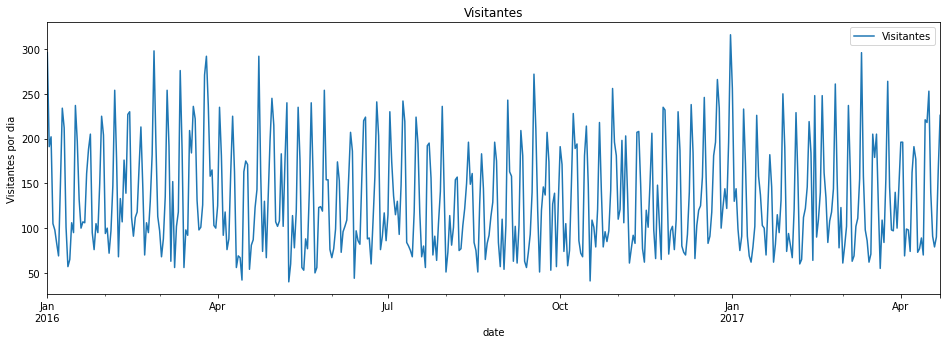

In [15]:
# Visualização dos dados

df1['total'].plot(label='Visitantes', legend=True, figsize=(16,5), title='Visitantes', ylabel='Visitantes por dia');

**4. Marque os feriados com linhas verticais em cinza.**

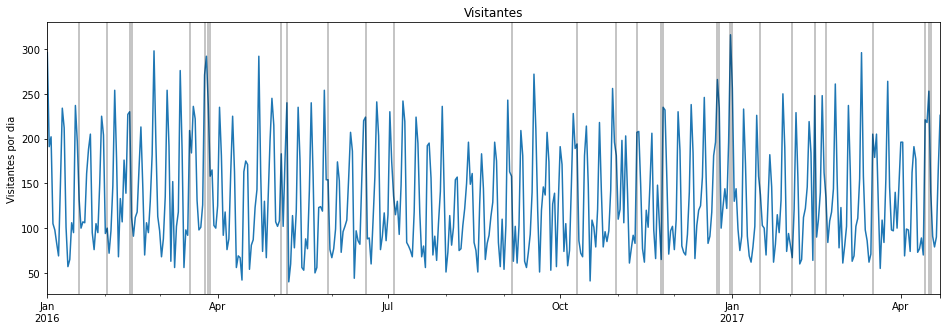

In [18]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

**5. Faça uma decomposição da série em tendência e sazonalidade.**

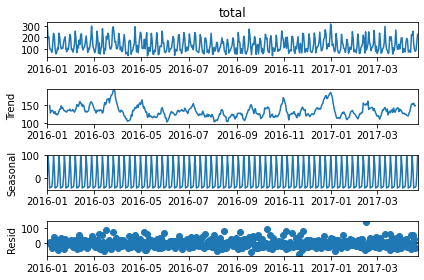

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df1['total'], model='additive' )  # model='add' also works
result.plot();

**6. Verifique a estacionariedade da série.**

Testando estacionariedade<br>
fonte: https://machinelearningmastery.com/time-series-data-stationary-python/

In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df1['total'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.592497
p-value: 0.000001
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


p-value baixo, portanto série estacionária
    

**7. Escolha um modelo SARIMA permitindo termos com sazonalidade 7.**


In [21]:
# Ajuste de modelo SARIMA 

stepwise_fit = auto_arima(df1['total'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=4785.816, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5269.484, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4916.749, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5049.644, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6126.084, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=5093.130, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=4926.360, Time=0.23 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=4971.200, Time=1.13 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=4976.544, Time=0.76 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=5010.582, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=4859.706, Time=1.06 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=4794.759, Time=0.55 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2388.908
Date:                   Tue, 17 Aug 2021   AIC                           4785.816
Time:                           10:31:12   BIC                           4802.494
Sample:                                0   HQIC                          4792.373
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5627      1.888      2.946      0.003       1.862       9.264
ar.S.L7        0.9531      0.015     64.267      0.000       0.924       0.982
ma.S.L7       -0.7002      0.053    -13.205      0.000      -0.804      -0.596
sigma2      1288.6450     80.607     15.987      0.000    1130.658    1446.632
===================================================================================
Ljung-Box (L1) (Q):                  15.67   Jarque-Bera (JB):                57.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.71
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**8. Separe uma base de treino e teste. A base de treino pode ter 80% das observações totais.**


In [22]:
len(df1)

478

In [23]:
len(df1)*0.8

382.40000000000003

In [26]:
train = df1.iloc[:382]
test = df1.iloc[382:]

**9. Vamos ajustar um modelo SARIMA (0,0,0)x(1,0,1)7 para os dados de treino.**

In [27]:
# Definição de variáveis endógenas e exógenas 
endog = train['total']
exog = train['holiday']
# exog = sm.add_constant(train['holiday']) #+ inclusão de intercepto para exog


In [29]:
modelo = sm.tsa.statespace.SARIMAX(endog, exog, order=(0,0,0), seasonal_order=(1, 0, 1, 7))
resultado = modelo.fit(disp=False)
print(resultado.summary())

                                 SARIMAX Results                                 
Dep. Variable:                     total   No. Observations:                  382
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -1842.932
Date:                   Tue, 17 Aug 2021   AIC                           3693.863
Time:                           10:42:56   BIC                           3709.645
Sample:                       01-01-2016   HQIC                          3700.124
                            - 01-16-2017                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       70.2799      5.088     13.814      0.000      60.308      80.252
ar.S.L7        0.9999   8.96e-05   1.12e+04      0.000       1.000       1.000
ma.S.L7       -0.9389      0

**10.  Obtenha os valores preditos. É importante estabelecer em predict a variável exógena.**

In [30]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # Por que não usar apenas colchetes simples?
previsao = resultado.predict(start=start, end=end, exog=exog_forecast).rename('Previsões SARIMAX(0,0,0)(1,0,1,7)')

Os colchetes internos são para lista e os colchetes externos são operadores de indexação, ou seja, você deve usar colchetes duplos se selecionar duas ou mais colunas. Com um nome de coluna, um único par de colchetes retorna uma série, enquanto os colchetes duplos retornam um dataframe.

**11. Observe as previsões do modelo e compare com a base de teste.**

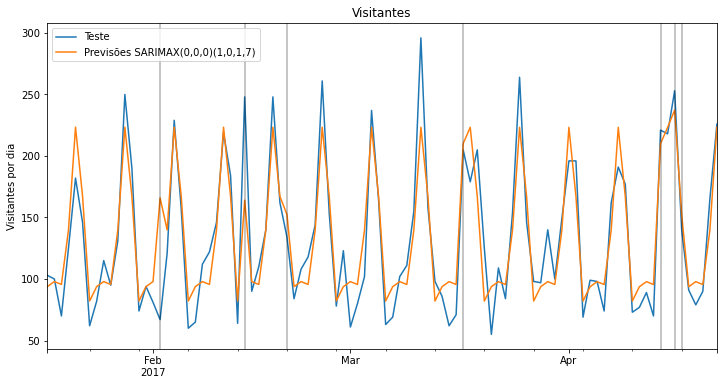

In [31]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''


ax = test['total'].plot(legend=True,figsize=(12,6),title=title, label='Teste')
previsao.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

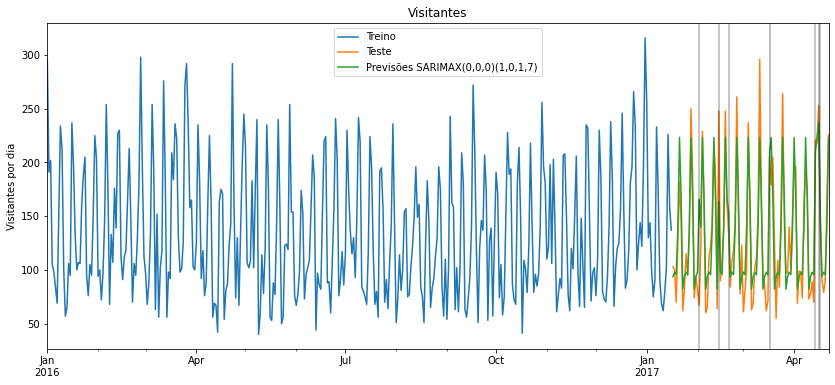

In [32]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''

train['total'].plot(legend=True,label='Treino')

ax = test['total'].plot(legend=True,figsize=(14,6),title=title, label='Teste')
previsao.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**12. Faça as previsões para as próximas observações, com os feriados disponíveis na base. Nesse caso, não fará diferença a previsão passo à frente ou dinâmica.**

In [36]:
# Usando todo o conjunto de dados
modelo = sm.tsa.statespace.SARIMAX(df1['total'],exog=df1['holiday'],order=(0,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
resultado = modelo.fit()
exog_forecast = df[478:][['holiday']]
# exog_forecast = df1[478:][['holiday']] # com df1 dá erro

In [37]:
# Previsão um passo a frente. Sugestão: Use get_prediction(len(df1),len(df1)+28,exog=exog_forecast)

previsao = resultado.get_prediction(len(df1),len(df1)+38,exog=exog_forecast)
previsao_ip = previsao.conf_int()

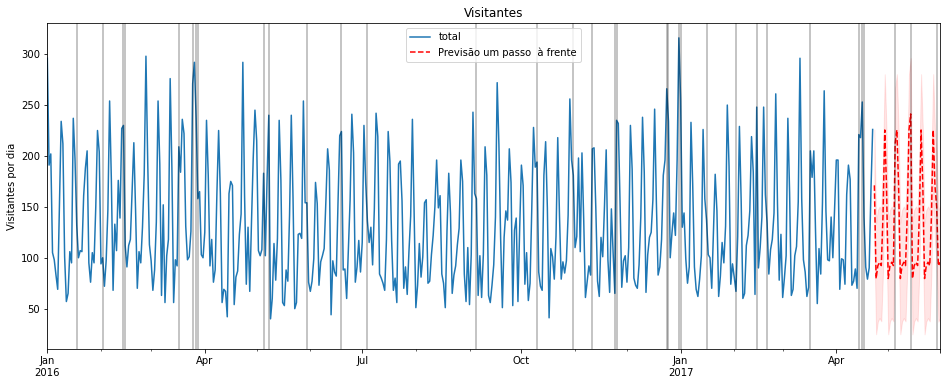

In [38]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)

previsao.predicted_mean.plot(ax=ax, style='r--', label='Previsão um passo  à frente', legend=True)
ip = previsao_ip.loc['2017-04-23':]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)


ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**Para essa aplicação, escolher a previsão dinâmica dynamic=data_previsao_dinamica levará aos mesmos resultados na prática.**

In [40]:
df1.tail(1)

,weekday,holiday,holiday_name,total
date,,,,
2017-04-22,Saturday,0,na,226.0


In [41]:
# Previsão dinâmica

data_previsao_dinamica = '2017-04-23'

previsao_di = resultado.get_prediction(len(df1),len(df1)+38, dynamic=data_previsao_dinamica, exog=exog_forecast)
previsao_di_ip = previsao_di.conf_int()

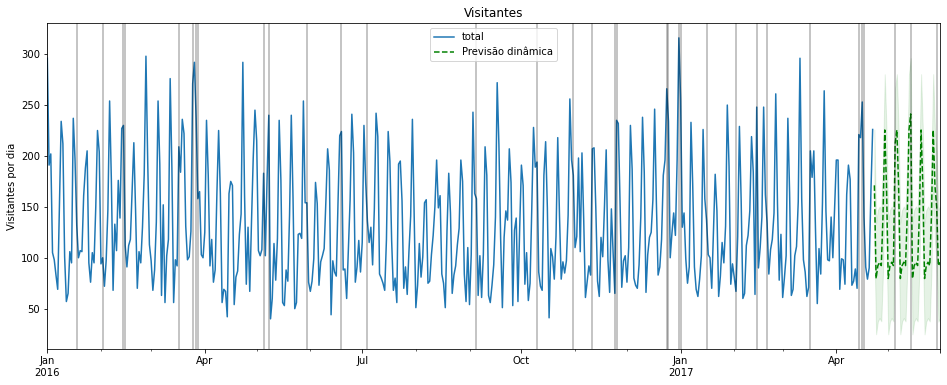

In [42]:
title='Visitantes'
ylabel='Visitantes por dia'
xlabel=''


ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)

previsao_di.predicted_mean.plot(ax=ax, style='g--', label='Previsão dinâmica', legend=True)
ip = previsao_di_ip.loc['2017-04-23':]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='g', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

**Prática extra:**

Ajuste e interprete um modelo Bayesiano para a demanda de eletricidade disponível em

https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html